In [2]:
import os
import sys

import logging
import re
import pathlib

import datetime

import numpy as np
import pandas as pd
from scipy.stats import pearsonr

import matplotlib.pyplot as plt

from pyplink import PyPlink

import statsmodels.api as sm

from basic_tools import *

"""

jupyter nbconvert 5_association.ipynb --to script
python 5_association.py albumin 2 0

for i in {00..101};do python 5_association.py $i 2 0,1,2;done


for i in {00..10};do python 5_association.py $i 2 0;done
for i in {11..20};do python 5_association.py $i 7 0;done
for i in {21..30};do python 5_association.py $i 7 0;done
for i in {31..40};do python 5_association.py $i 7 0;done
for i in {41..50};do python 5_association.py $i 7 0;done
for i in {51..60};do python 5_association.py $i 7 0;done
for i in {61..70};do python 5_association.py $i 7 0;done
for i in {71..80};do python 5_association.py $i 7 0;done
for i in {81..90};do python 5_association.py $i 7 0;done
for i in {91..101};do python 5_association.py $i 7 0;done

for i in {101};do python 5_association.py $i 5 0;done
for i in {51..60};do python 5_association.py $i 5 0;done
for i in {51..60};do python 5_association.py $i 5 0;done
for i in {51..60};do python 5_association.py $i 5 0;done

for i in {00..101};do python 5_association.py $i 1 0,2;done
for i in {00..101};do python 5_association.py $i 1 1;done

for i in {00..20};do python 5_association.py $i 1 1;done
for i in {21..40};do python 5_association.py $i 1 1;done
for i in {41..60};do python 5_association.py $i 1 1;done
for i in {61..80};do python 5_association.py $i 1 1;done
for i in {81..101};do python 5_association.py $i 1 1;done

"""

'\n\njupyter nbconvert 5_association.ipynb --to script\npython 5_association.py albumin 2 0\n\nfor i in {00..101};do python 5_association.py $i 2 0,1,2;done\n\n\nfor i in {00..10};do python 5_association.py $i 2 0;done\nfor i in {11..20};do python 5_association.py $i 7 0;done\nfor i in {21..30};do python 5_association.py $i 7 0;done\nfor i in {31..40};do python 5_association.py $i 7 0;done\nfor i in {41..50};do python 5_association.py $i 7 0;done\nfor i in {51..60};do python 5_association.py $i 7 0;done\nfor i in {61..70};do python 5_association.py $i 7 0;done\nfor i in {71..80};do python 5_association.py $i 7 0;done\nfor i in {81..90};do python 5_association.py $i 7 0;done\nfor i in {91..101};do python 5_association.py $i 7 0;done\n\nfor i in {101};do python 5_association.py $i 5 0;done\nfor i in {51..60};do python 5_association.py $i 5 0;done\nfor i in {51..60};do python 5_association.py $i 5 0;done\nfor i in {51..60};do python 5_association.py $i 5 0;done\n\nfor i in {00..101};do py

In [3]:
plink_KCHIP_HLA_AA_SNP_1000G=PyPlink(plink_KCHIP_HLA_AA_SNP_1000G_path)
plink_KCHIP_HLA_AA_SNP_1000G_fam=plink_KCHIP_HLA_AA_SNP_1000G.get_fam().astype({'fid':str,'iid':str}).rename(columns={'fid':'FID','iid':'IID'})
plink_KCHIP_HLA_AA_SNP_1000G_bim=plink_KCHIP_HLA_AA_SNP_1000G.get_bim()

In [4]:
phenotypes=pd.read_csv(pheno_all_file_path,sep='\t')
phenotypes=phenotypes.set_index('ID').loc[plink_KCHIP_HLA_AA_SNP_1000G_fam['IID']]

binary_continuous_traits=sorted(phenotypes.columns[~phenotypes.columns.str.contains('x_ray')])
#binary_continuous_traits

if 'ipykernel' in sys.argv[0]:
    ipykernel=True
    phenotype_name='height'
    step_idx=3
    mode_list=[0]
    #phenotype_name='height'
else:
    ipykernel=False
    phenotype_name=sys.argv[1]
    step_idx=int(sys.argv[2])
    mode_list=[int(i) for i in sys.argv[3].strip().split(',')]
    
if phenotype_name.isdigit():
    phenotype_name=int(phenotype_name)
    phenotype_name=binary_continuous_traits[phenotype_name]      

In [5]:
data_out_assoc_phenotype_path=data_out_assoc_path+phenotype_name+'/'
pathlib.Path(data_out_assoc_phenotype_path).mkdir(parents=True, exist_ok=True)

In [6]:
for i in binary_continuous_traits:
    if not os.path.exists('data/out_assoc/{}/step_01.plink.PHENO2.glm.linear'.format(i)) and not os.path.exists('data/out_assoc/{}/step_01.plink.PHENO2.glm.logistic'.format(i)):
        print(i)

sex


In [7]:
pheno=pd.read_csv(data_out_pheno_path+phenotype_name+'.phe',sep='\t',names=['FID','IID','pheno'])
phenotype_type='binary' if len(pheno['pheno'][pheno['pheno']!=-9].value_counts())<3 else 'continuous'
phenotype_type

'continuous'

In [8]:
log = logging.getLogger('logger')
log.setLevel(logging.DEBUG)

log_file_name=datetime.datetime.now().strftime('%Y%m%d_%H%M%S')+'.log'
log_file_path=data_out_assoc_phenotype_path+log_file_name
fileHandler = logging.FileHandler(log_file_path)
streamHandler = logging.StreamHandler()

formatter = logging.Formatter('%(message)s')
fileHandler.setFormatter(formatter)
streamHandler.setFormatter(formatter)

log.addHandler(fileHandler)
log.addHandler(streamHandler)

In [9]:
for step_idx_sub in range(1,step_idx):
    if os.path.exists(data_out_assoc_phenotype_path+'step_{:02d}.cond.stop'.format(step_idx_sub)):
        log.info("step_{}.cond.stop->stops ".format(step_idx_sub))
        sys.exit()

In [10]:
log.info_head=lambda x: log.info('-'*int((100-len(x))/2)+x+'-'*int((100-len(x))/2))

In [11]:
log.info_head("phenotype_name: {}, phenotype_type:{} , Step : {} ".format(phenotype_name,phenotype_type,step_idx))

-------------------phenotype_name: height, phenotype_type:continuous , Step : 3 -------------------


In [12]:
#os.path.exists(data_out_assoc_phenotype_path+'step_{:02d}.cond.stop'.format(step_idx))

In [13]:
for step_idx_sub in range(1,step_idx+1):

    if os.path.exists(data_out_assoc_phenotype_path+'step_{:02d}.cond.stop'.format(step_idx_sub)):
        log.info("stops cond.stop")
        sys.exit()

In [14]:
gene_bed_path='data/known_genes_chr6.hg18.txt'
gene_bed=pd.read_csv(gene_bed_path,sep='\t')
gene_bed=gene_bed[(gene_bed['txStart']>=plink_KCHIP_HLA_AA_SNP_1000G_bim.pos.min())&(gene_bed['txEnd']<=plink_KCHIP_HLA_AA_SNP_1000G_bim.pos.max())]
gene_bed=gene_bed[~gene_bed.duplicated(['name2'])]

gene_assign=plink_KCHIP_HLA_AA_SNP_1000G_bim[['pos']]

for idx,row in gene_bed.iterrows():
    gene_assign[row['name2']]=0
    
for idx,row in gene_bed.iterrows():    
    gene_assign[row['name2']][(gene_assign['pos']>=row['txStart'])&(gene_assign['pos']<=row['txEnd'])]=1

gene_assign.columns=gene_assign.columns.str.replace('HLA-','HLA_')        
    
HLA_names=np.unique([i[0].split('_')[1] for i in plink_KCHIP_HLA_AA_SNP_1000G_bim[plink_KCHIP_HLA_AA_SNP_1000G_bim.index.str.contains('HLA_')].index.str.split('*')])

for HLA_name in HLA_names:
    HLA_name='HLA_{}'.format(HLA_name)
    gene_select=gene_assign[gene_assign.index.str.contains('HLA_'+HLA_name)|gene_assign.index.str.contains('SNPS_'+HLA_name)|gene_assign.index.str.contains('AA_'+HLA_name)]#print(gene_select.sort_values('pos').iloc[0],gene_select.sort_values('pos').iloc[-1])
    gene_assign[HLA_name][(gene_assign['pos']>=gene_select['pos'].min())&(gene_assign['pos']<=gene_select['pos'].max())]=1 

/home/ch6845/tools/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [15]:
covariate_df=pd.read_csv(PC_path,sep='\t').set_index('ID').loc[plink_KCHIP_HLA_AA_SNP_1000G_fam['IID']]
covariate_df['age']=phenotypes['age']
covariate_df['sex']=phenotypes['sex']-1

if np.all((pheno['pheno']==-9) | ((phenotypes['cohort']==1)|(phenotypes['cohort']==2))):
    covariate_df['AS']=phenotypes['cohort'].replace(1,1).replace(2,0).replace(3,0)
else:
    covariate_df['AS']=phenotypes['cohort'].replace(1,1).replace(2,0).replace(3,0)
    covariate_df['CT']=phenotypes['cohort'].replace(1,0).replace(2,1).replace(3,0)
plink_KCHIP_HLA_AA_SNP_1000G_fam.iloc[:,:2].merge(right=covariate_df,left_on='IID',right_index=True).fillna(-9).to_csv(data_out_assoc_phenotype_path+'covar',index=None,sep='\t')

In [16]:
phenotypes.index[phenotypes['cohort']==1]

Index(['BHAN005531', 'BHAN005532', 'BHAN005533', 'BHAN005534', 'BHAN005535',
       'BHAN005536', 'BHAN005537', 'BHAN005538', 'BHAN005539', 'BHAN005540',
       ...
       'BHAN013133', 'BHAN013134', 'BHAN013135', 'BHAN013136', 'BHAN013137',
       'BHAN013138', 'BHAN013139', 'BHAN013140', 'BHAN013141', 'BHAN013142'],
      dtype='object', name='ID', length=7607)

In [18]:
#pheno['pheno'].loc[phenotypes.index[phenotypes['cohort']==1]].value_counts()

In [19]:
pheno.set_index('IID').loc[phenotypes.index[phenotypes['cohort']==3]]['pheno'].value_counts()

-9.0      187
 150.0    150
 154.0    146
 155.0    146
 152.0    141
 151.0    141
 156.0    139
 157.0    138
 158.0    123
 153.0    121
 160.0    113
 159.0    112
 154.5    106
 161.0    104
 163.0    103
 155.5    103
 153.5     99
 162.0     99
 150.8     98
 149.0     96
 155.4     96
 157.5     95
 151.5     95
 153.9     95
 165.0     95
 156.6     93
 152.5     93
 152.4     91
 158.3     91
 150.5     90
         ... 
 179.5      2
 183.1      2
 140.2      2
 180.7      2
 139.0      2
 138.3      2
 182.6      1
 183.3      1
 179.1      1
 137.3      1
 138.1      1
 136.8      1
 183.2      1
 180.9      1
 136.5      1
 184.8      1
 180.1      1
 136.0      1
 183.7      1
 181.1      1
 184.1      1
 136.9      1
 179.3      1
 182.0      1
 180.4      1
 180.5      1
 182.2      1
 179.2      1
 181.2      1
 177.9      1
Name: pheno, Length: 471, dtype: int64

In [20]:
pheno.set_index('IID').loc[phenotypes.index[phenotypes['cohort']==1]]['pheno'].value_counts()

166.0    137
168.0    121
167.0    120
154.0    116
156.0    114
152.0    112
153.0    110
155.0    109
165.0    107
160.0    107
158.0    104
163.0    103
162.0    100
164.0    100
161.0     97
157.0     96
170.0     94
169.0     90
159.0     88
167.5     83
151.0     81
166.5     74
164.5     74
150.0     73
153.5     72
173.0     70
171.0     69
162.5     69
154.5     69
168.5     69
        ... 
139.3      1
137.3      1
182.1      1
179.6      1
143.4      1
184.7      1
174.9      1
139.5      1
136.4      1
178.4      1
180.3      1
176.4      1
139.8      1
136.3      1
138.9      1
144.8      1
140.7      1
142.1      1
141.3      1
177.1      1
175.7      1
143.8      1
182.6      1
182.3      1
181.4      1
142.9      1
139.9      1
139.6      1
174.7      1
183.4      1
Name: pheno, Length: 413, dtype: int64

In [21]:
pheno.set_index('IID').loc[phenotypes.index[phenotypes['cohort']==2]]['pheno'].value_counts()

158.0    2970
160.0    2901
157.0    2579
156.0    2541
155.0    2514
159.0    2390
154.0    2257
153.0    2246
162.0    2121
161.0    2096
163.0    2043
152.0    1828
165.0    1817
164.0    1781
168.0    1619
170.0    1578
151.0    1516
166.0    1497
150.0    1486
167.0    1465
169.0    1282
171.0    1188
172.0    1141
173.0     967
149.0     839
174.0     793
175.0     737
148.0     735
176.0     552
147.0     485
         ... 
140.8       3
182.2       3
140.7       3
184.7       2
139.9       2
141.1       2
183.8       2
139.8       2
183.1       2
141.3       2
135.6       2
139.5       2
139.3       2
138.6       2
139.7       2
140.9       2
138.1       1
137.9       1
136.5       1
137.6       1
135.9       1
136.2       1
138.5       1
139.1       1
135.8       1
140.4       1
138.8       1
135.7       1
138.4       1
139.6       1
Name: pheno, Length: 477, dtype: int64

In [22]:
"""
#r2_df.loc[gene_assign.index[gene_assign['HLA_DPB1']==1]].sort_values(0)
r2_list=[]
for idx_bim,(SNP,row) in enumerate(plink_KCHIP_HLA_AA_SNP_1000G_bim.iterrows()):
    r2=pearsonr(plink_KCHIP_HLA_AA_SNP_1000G.get_geno_marker('6:31367865_G/A'),plink_KCHIP_HLA_AA_SNP_1000G.get_geno_marker(SNP))[0]**2
    r2_list.append(r2)
r2_df=pd.DataFrame(r2_list,index=plink_KCHIP_HLA_AA_SNP_1000G_bim.index)  
#r2_df.loc['6:32665115_T/C']

r2_df.loc[gene_assign.index[gene_assign['HLA_B']==1]].sort_values(0)
"""


"\n#r2_df.loc[gene_assign.index[gene_assign['HLA_DPB1']==1]].sort_values(0)\nr2_list=[]\nfor idx_bim,(SNP,row) in enumerate(plink_KCHIP_HLA_AA_SNP_1000G_bim.iterrows()):\n    r2=pearsonr(plink_KCHIP_HLA_AA_SNP_1000G.get_geno_marker('6:31367865_G/A'),plink_KCHIP_HLA_AA_SNP_1000G.get_geno_marker(SNP))[0]**2\n    r2_list.append(r2)\nr2_df=pd.DataFrame(r2_list,index=plink_KCHIP_HLA_AA_SNP_1000G_bim.index)  \n#r2_df.loc['6:32665115_T/C']\n\nr2_df.loc[gene_assign.index[gene_assign['HLA_B']==1]].sort_values(0)\n"

In [23]:
#pheno['pheno'].loc[pheno['pheno']!=-9]
#covariate_df['age']
#pheno['pheno']

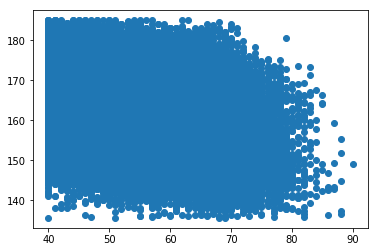

In [24]:
plt.scatter(covariate_df['age'].loc[pheno.set_index('IID')['pheno']!=-9],pheno.set_index('IID')['pheno'].loc[pheno.set_index('IID')['pheno']!=-9])

In [25]:
(plink_KCHIP_HLA_AA_SNP_1000G.get_geno_marker('6:34207474_T/TAA')==0).sum(),(plink_KCHIP_HLA_AA_SNP_1000G.get_geno_marker('6:34207474_T/TAA')==1).sum(),(plink_KCHIP_HLA_AA_SNP_1000G.get_geno_marker('6:34207474_T/TAA')==2).sum()

(88310, 34175, 3188)

In [26]:
((plink_KCHIP_HLA_AA_SNP_1000G.get_geno_marker('6:34207474_T/TAA')==1).sum()+2*(plink_KCHIP_HLA_AA_SNP_1000G.get_geno_marker('6:34207474_T/TAA')==2).sum())/\
(2*len(((plink_KCHIP_HLA_AA_SNP_1000G.get_geno_marker('6:34207474_T/TAA')))))

0.16133537036594972

In [27]:
(plink_KCHIP_HLA_AA_SNP_1000G.get_geno_marker('6:34207474_T/TAA')==-1).sum()

0

In [28]:
phenotypes['cohort']==1

ID
BHAN000001    False
BHAN000002    False
BHAN000003    False
BHAN000004    False
BHAN000005    False
BHAN000006    False
BHAN000007    False
BHAN000008    False
BHAN000009    False
BHAN000010    False
BHAN000011    False
BHAN000012    False
BHAN000013    False
BHAN000014    False
BHAN000015    False
BHAN000016    False
BHAN000017    False
BHAN000018    False
BHAN000019    False
BHAN000020    False
BHAN000021    False
BHAN000022    False
BHAN000023    False
BHAN000024    False
BHAN000025    False
BHAN000026    False
BHAN000027    False
BHAN000028    False
BHAN000029    False
BHAN000030    False
              ...  
BHAN125843    False
BHAN125844    False
BHAN125845    False
BHAN125846    False
BHAN125847    False
BHAN125848    False
BHAN125849    False
BHAN125850    False
BHAN125851    False
BHAN125852    False
BHAN125853    False
BHAN125854    False
BHAN125855    False
BHAN125856    False
BHAN125857    False
BHAN125858    False
BHAN125859    False
BHAN125860    False
BHAN125861    Fal

In [29]:
#plink_KCHIP_HLA_AA_SNP_1000G_fam.iloc[:,:2].merge(right=covariate_df,left_on='IID',right_index=True)

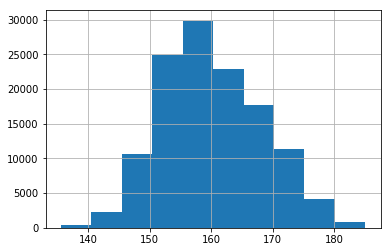

In [30]:
pheno['pheno'].replace(-9,np.nan).hist()

(160.08831947662534, <matplotlib.axes._subplots.AxesSubplot at 0x7fee3030ab38>)

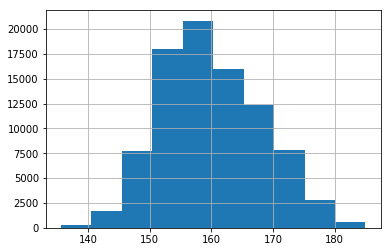

In [31]:
pheno['pheno'][plink_KCHIP_HLA_AA_SNP_1000G.get_geno_marker('6:34207474_T/TAA')==0].replace(-9,np.nan).mean(),pheno['pheno'][plink_KCHIP_HLA_AA_SNP_1000G.get_geno_marker('6:34207474_T/TAA')==0].replace(-9,np.nan).hist()

(160.6102763664131, <matplotlib.axes._subplots.AxesSubplot at 0x7fee302fbe80>)

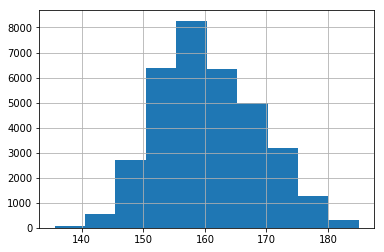

In [32]:
pheno['pheno'][plink_KCHIP_HLA_AA_SNP_1000G.get_geno_marker('6:34207474_T/TAA')==1].replace(-9,np.nan).mean(),pheno['pheno'][plink_KCHIP_HLA_AA_SNP_1000G.get_geno_marker('6:34207474_T/TAA')==1].replace(-9,np.nan).hist()

(161.06531062756227, <matplotlib.axes._subplots.AxesSubplot at 0x7fede4767160>)

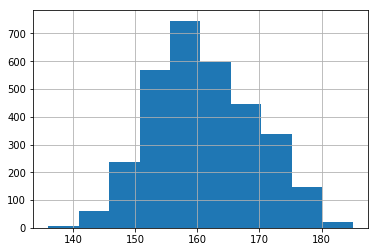

In [33]:

pheno['pheno'][plink_KCHIP_HLA_AA_SNP_1000G.get_geno_marker('6:34207474_T/TAA')==2].replace(-9,np.nan).mean(),pheno['pheno'][plink_KCHIP_HLA_AA_SNP_1000G.get_geno_marker('6:34207474_T/TAA')==2].replace(-9,np.nan).hist()

In [117]:
if 0 in mode_list:
    if os.path.exists(data_out_assoc_phenotype_path+'step_{:02d}.cond'.format(step_idx)):
        log.warning("Tried to construct .cond but. cond already exists")
    else:
        if step_idx==1:
            conditional_list=[]
            pd.Series(conditional_list).to_csv(data_out_assoc_phenotype_path+'step_{:02d}.cond'.format(step_idx),index=None,sep='\t',header=False)                        
        else:
            conditional_list=[]
            for step_idx_sub in range(1,step_idx):
                log.info("step idx sub {} cond finding".format(step_idx_sub))
                GAT_result=pd.read_csv(data_out_assoc_phenotype_path+'step_{:02d}.GAT.result.tsv'.format(step_idx_sub),sep='\t')
                plink_result=pd.read_csv(data_out_assoc_phenotype_path+'step_{:02d}.plink.PHENO2.glm.{}'.format(step_idx_sub,'logistic' if phenotype_type=='binary' else 'linear'),sep='\t')

                plink_result_munge=plink_result[plink_result['TEST']=='ADD'].drop(columns='#CHROM').rename(columns={'TEST':'term','ID':'marker_name','BETA':'coef','SE':'std','T_STAT':'Z','Z_STAT':'Z','OBS_CT':'nobs'})
                plink_result_munge['A2']=plink_result_munge.apply(lambda x: x['ALT'] if x['A1']==x['REF'] else x['REF'],axis=1)
                plink_result_munge=plink_result_munge.drop(columns=['REF','ALT'])
                plink_result_munge['note']='unphased bialleic'  
                result_merge=pd.concat([GAT_result,plink_result_munge],sort=True)[['marker_name','note','term','POS','Z','coef','std','chisq','df','A1','A2','multi_allele','nobs','P']]
            
                result_merge_sorted=result_merge.astype({'P':float}).sort_values('P')   

                result_merge.to_csv(data_out_assoc_phenotype_path+'step_{:02d}.result.tsv'.format(step_idx_sub),index=None,sep='\t',header=True)                                        
                result_merge_sorted.to_csv(data_out_assoc_phenotype_path+'step_{:02d}.result_sorted.tsv'.format(step_idx_sub),index=None,sep='\t',header=True)                                        
                
                log.info(result_merge_sorted.iloc[:5])
                if np.isnan(result_merge_sorted.iloc[0]['P']) or result_merge_sorted.iloc[0]['P']>5e-8:
                    pd.Series(conditional_list).to_csv(data_out_assoc_phenotype_path+'step_{:02d}.cond.stop'.format(step_idx),index=None,sep='\t',header=False)                        
                    log.info("p value insignificant")
                    break

                marker_name=result_merge_sorted.iloc[0].marker_name

                

                if marker_name[:3]=='AA_':
                    conditional_list.append('HLA_'+marker_name.split('_')[1])
                elif marker_name[:5]=='SNPS_':
                    conditional_list.append('HLA_'+marker_name.split('_')[1])
                elif marker_name[:4]=='HLA_':
                    conditional_list.append('HLA_'+marker_name.split('_')[1].split('*')[0])
                elif marker_name[:9]=='INS_SNPS_':
                    conditional_list.append('HLA_'+marker_name.split('_')[2])
                else:
                    #conditional_list.append(marker_name)                    
                    r2_list=[]
                    for idx_bim,(SNP,row) in enumerate(plink_KCHIP_HLA_AA_SNP_1000G_bim.iterrows()):
                        r2=pearsonr(plink_KCHIP_HLA_AA_SNP_1000G.get_geno_marker(marker_name),plink_KCHIP_HLA_AA_SNP_1000G.get_geno_marker(SNP))[0]**2
                        r2_list.append(r2)
                    r2_df=pd.DataFrame(r2_list,index=plink_KCHIP_HLA_AA_SNP_1000G_bim.index)                

                    if gene_assign[r2_df[0]>0.95][['HLA_A', 'HLA_B', 'HLA_C', 'HLA_DPA1', 'HLA_DPB1', 'HLA_DQA1', 'HLA_DQB1', 'HLA_DRB1']].sum().sum()==0:
                        conditional_list.append(marker_name)                     
                        log.info("{} not in HLA polymorphism-> added".format(marker_name))
                        
                    HLA_count=gene_assign[r2_df[0]>0.7][['HLA_A', 'HLA_B', 'HLA_C', 'HLA_DPA1', 'HLA_DPB1', 'HLA_DQA1', 'HLA_DQB1', 'HLA_DRB1']].sum(axis=0).sort_values(ascending=False)
                    print(HLA_count[HLA_count>0].index)
                    for i in HLA_count[HLA_count>0].index:
                        print(i)
                        conditional_list.append(i)
                        log.info("{} is strong LD with {}".format(marker_name,i))
                        break
                
                log.info('step idx {} conditional_list: {}'.format(step_idx_sub,conditional_list))
                conditional_list=np.unique(conditional_list).tolist()
                if step_idx_sub==step_idx-1:
                    pd.Series(conditional_list).to_csv(data_out_assoc_phenotype_path+'step_{:02d}.cond'.format(step_idx),index=None,sep='\t',header=False)                        
                
        log.info('conditional_list: {}'.format(conditional_list))
                        

step idx sub 1 cond finding
step idx sub 1 cond finding
           marker_name               note term         POS        Z  std  \
457290  6:32639786_G/A  unphased bialleic  ADD  32639786.0  8.70439  NaN   
456309  6:32638199_C/G  unphased bialleic  ADD  32638199.0  8.70439  NaN   
462807  6:32650159_C/T  unphased bialleic  ADD  32650159.0  8.69955  NaN   
510381  6:32669373_C/T  unphased bialleic  ADD  32669373.0  8.67898  NaN   
507924  6:32665115_T/C  unphased bialleic  ADD  32665115.0  8.67589  NaN   

        chisq  coef  df A1 A2 multi_allele   nobs             P  
457290    NaN   NaN NaN  A  G          NaN  91494  3.192930e-18  
456309    NaN   NaN NaN  G  C          NaN  91494  3.192930e-18  
462807    NaN   NaN NaN  T  C          NaN  91494  3.331960e-18  
510381    NaN   NaN NaN  T  C          NaN  91494  3.993250e-18  
507924    NaN   NaN NaN  C  T          NaN  91494  4.103340e-18  
           marker_name               note term         POS        Z  std  \
457290  6:32639

KeyboardInterrupt: 

In [54]:
if 1 in mode_list:
    if not os.path.exists(data_out_assoc_phenotype_path+'step_{:02d}.cond'.format(step_idx)):
        log.warning("cond not existing... stop GAT...") 
        
        
    elif os.path.exists(data_out_assoc_phenotype_path+'step_{:02d}.GAT.result.tsv'.format(step_idx)):
        log.warning("GAT result already exits") 
        
    else:
        log.info("######################################### step {:02d} Phased Association  #########################################".format(step_idx))


        command='python Generic_Association_Tool/GAT.py \
        --assoc {assoc_mode} \
        --out {out} \
        --bfile {bfile} \
        --bgl-phased {bgl_phased} \
        --pheno {pheno} \
        --covar {covar} \
        --condition-list {cond} \
        --skip "(?P<name>6:[0-9]*_[A-Z]*/[\<\>A-Z\:0-9]*),(?P<name>rs[0-9]*),(?P<name>SNPS_.*),(?P<name>INS_SNPS_.*)" \
        --multialleic "(?P<name>HLA_[0-9A-Z]*)\*(?P<allele>[0-9:]*)" \
        --multialleic-always "(?P<name>AA_[A-Z0-9]*_[\-0-9]*_[0-9]*_exon[0-9]*)_*(?P<allele>[A-Z]*)"'.format(
        assoc_mode='logistic' if phenotype_type=='binary' else 'linear',
        out=data_out_assoc_phenotype_path+'step_{:02d}.GAT'.format(step_idx),
        bfile=plink_1000G_path,
        bgl_phased=phased_KCHIP_HLA_AA_SNP_path,
        pheno=data_out_pheno_path+phenotype_name+'.phe',
        covar=data_out_assoc_phenotype_path+'covar',   
        cond=data_out_assoc_phenotype_path+'step_{:02d}.cond'.format(step_idx)  
        )    

        log.info(command)
        stdout,stderr=run_subprocess(command,dry=False)
        log.info(stdout)
        log.error(stderr) 



if 2 in mode_list:
    if not os.path.exists(data_out_assoc_phenotype_path+'step_{:02d}.cond'.format(step_idx)):
        log.warning("cond not existing... stop plink...") 

    elif os.path.exists(data_out_assoc_phenotype_path+'step_{:02d}.plink.PHENO2.glm.{}'.format(step_idx,'logistic' if phenotype_type=='binary' else 'linear')):
        log.warning("plink result already exits")         
        
    else:    
        log.info("######################################### step {:02d} Unphased Association  #########################################".format(step_idx))

        command='plink2 \
        --bfile {bfile} \
        {assoc_mode} \
        --pheno {pheno} \
        --covar {covar} \
        --out {out} \
        --covar-variance-standardize \
        --threads 40'.format(
        bfile=plink_KCHIP_SNP_1000G_path,
        assoc_mode='--logistic' if phenotype_type=='binary' else '--linear',
        pheno=data_out_pheno_path+phenotype_name+'.phe',
        covar=data_out_assoc_phenotype_path+'step_{:02d}.GAT.covar_unphased.tsv'.format(step_idx),
        out=data_out_assoc_phenotype_path+'step_{:02d}.plink'.format(step_idx)                                                                         
        )

        log.info(command)
        stdout,stderr=run_subprocess(command,dry=False)
        log.info(stdout)
        log.error(stderr)  


